# 1. Import Libraries

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score


from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# 2. Load the Dataset

In [104]:
path = '/content/laptop_price - dataset.csv'
dataset = pd.read_csv(path)
print("Dataset Loaded:\n", dataset.head())

Dataset Loaded:
   Company      Product   TypeName  Inches                    ScreenResolution  \
0   Apple  MacBook Pro  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   
1   Apple  Macbook Air  Ultrabook    13.3                            1440x900   
2      HP       250 G6   Notebook    15.6                   Full HD 1920x1080   
3   Apple  MacBook Pro  Ultrabook    15.4  IPS Panel Retina Display 2880x1800   
4   Apple  MacBook Pro  Ultrabook    13.3  IPS Panel Retina Display 2560x1600   

  CPU_Company       CPU_Type  CPU_Frequency (GHz)  RAM (GB)  \
0       Intel        Core i5                  2.3         8   
1       Intel        Core i5                  1.8         8   
2       Intel  Core i5 7200U                  2.5         8   
3       Intel        Core i7                  2.7        16   
4       Intel        Core i5                  3.1         8   

                Memory GPU_Company                GPU_Type  OpSys  \
0            128GB SSD       Intel  Iris Plus Gr

In [105]:
print(dataset.shape)

(1275, 15)


In [106]:
print(dataset.isnull().sum())

Company                0
Product                0
TypeName               0
Inches                 0
ScreenResolution       0
CPU_Company            0
CPU_Type               0
CPU_Frequency (GHz)    0
RAM (GB)               0
Memory                 0
GPU_Company            0
GPU_Type               0
OpSys                  0
Weight (kg)            0
Price (Euro)           0
dtype: int64


In [107]:
print(dataset.dtypes)

Company                 object
Product                 object
TypeName                object
Inches                 float64
ScreenResolution        object
CPU_Company             object
CPU_Type                object
CPU_Frequency (GHz)    float64
RAM (GB)                 int64
Memory                  object
GPU_Company             object
GPU_Type                object
OpSys                   object
Weight (kg)            float64
Price (Euro)           float64
dtype: object


# 3. Preprocess the Dataset

In [108]:
def preprocess_dataset(dataset, target_columns):

    # Encode categorical variables
    le = LabelEncoder()

    for column in dataset.select_dtypes(include=['object']).columns:
        dataset[column] = le.fit_transform(dataset[column])

    # Split dataset
    X = dataset.drop(columns=target_columns, axis=1)  # Features
    y = dataset[target_columns] # Target
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, 1)

    sc = MinMaxScaler()
    X = sc.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [109]:
X_train, X_test, y_train, y_test = preprocess_dataset(dataset, target_columns=['Price (Euro)'])
print("Data Preprocessing Completed.")

Data Preprocessing Completed.


In [110]:
print(dataset.dtypes)

Company                  int64
Product                  int64
TypeName                 int64
Inches                 float64
ScreenResolution         int64
CPU_Company              int64
CPU_Type                 int64
CPU_Frequency (GHz)    float64
RAM (GB)                 int64
Memory                   int64
GPU_Company              int64
GPU_Type                 int64
OpSys                    int64
Weight (kg)            float64
Price (Euro)           float64
dtype: object


# 4. Reference Bagging Regressor

In [111]:
estimators_numbers = [10, 20, 30, 40, 50]
execution_times = {}
r2_scores = {}

best_model = None
best_r2_score = 0
best_estimators_number = 0

for estimators_number in estimators_numbers:
  br_ref = model = BaggingRegressor(n_estimators=estimators_number)
  br_ref.fit(X_train, y_train)

  start_time = datetime.now()

  y_pred = br_ref.predict(X_test)

  end_time = datetime.now()

  # Metrics
  r2 = r2_score(y_test, y_pred)
  execution_time = (end_time - start_time).microseconds

  r2_scores[estimators_number] = r2
  execution_times[estimators_number] = execution_time

  if r2 > best_r2_score:
    best_r2_score = r2
    best_estimators_number = estimators_number
    best_model = br_ref

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ),

In [112]:
print("Estimators\tExecution Time\tR2 score")

for estimators_number in estimators_numbers:
  print(f"{estimators_number}\t\t{execution_times[estimators_number]}\t\t{r2_scores[estimators_number]:.4f}")

Estimators	Execution Time	R2 score
10		3579		0.8651
20		8200		0.8656
30		9464		0.8660
40		12447		0.8653
50		13173		0.8716


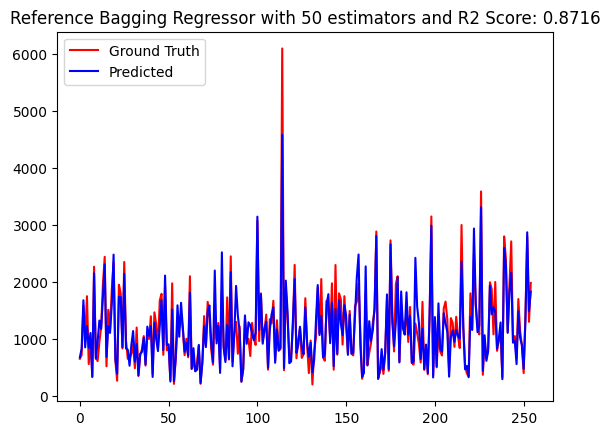

In [113]:
y_pred = best_model.predict(X_test)

plt.plot(y_test, color='red', label='Ground Truth')
plt.plot(y_pred, color='blue', label='Predicted')
plt.legend(loc='upper left')
plt.title(f"Reference Bagging Regressor with {best_estimators_number} estimators and R2 Score: {best_r2_score:.4f}")
plt.show()

# 5. Custom Bagging Regressor

In [114]:
class CustomBaggingRegressor:
    def __init__(self, n_estimators=10, base_test_threshold=0.75):
        self.n_estimators = n_estimators
        self.base_test_threshold = base_test_threshold

        self.estimators = []
        self.seeds = []


    def fit(self, X, y):
        while len(self.estimators) < self.n_estimators:
            model = DecisionTreeRegressor()
            seed = np.random.randint(1, 2**16)

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            test_score = r2_score(y_pred, y_test)

            if test_score > self.base_test_threshold:
                self.estimators.append(model)
                self.seeds.append(seed)


    def predict(self, X):
        results = []
        for estimator in self.estimators:
            y = estimator.predict(X)
            results.append(y)
        return np.mean(np.array(results), axis=0)

In [115]:
estimators_numbers = [10, 20, 30, 40, 50]
execution_times = {}
r2_scores = {}

best_model = None
best_r2_score = 0
best_estimators_number = 0

for estimators_number in estimators_numbers:
  br_cus = model = CustomBaggingRegressor(n_estimators=estimators_number)
  br_cus.fit(X_train, y_train)

  start_time = datetime.now()

  y_pred = br_cus.predict(X_test)

  end_time = datetime.now()

  # Metrics
  r2 = r2_score(y_test, y_pred)
  execution_time = (end_time - start_time).microseconds

  r2_scores[estimators_number] = r2
  execution_times[estimators_number] = execution_time

  if r2 > best_r2_score:
    best_r2_score = r2
    best_estimators_number = estimators_number
    best_model = br_cus

In [116]:
print("Estimators\tExecution Time\tR2 score")

for estimators_number in estimators_numbers:
  print(f"{estimators_number}\t\t{execution_times[estimators_number]}\t\t{r2_scores[estimators_number]:.4f}")

Estimators	Execution Time	R2 score
10		2427		0.8584
20		4646		0.8569
30		7461		0.8504
40		9890		0.8648
50		11744		0.8594


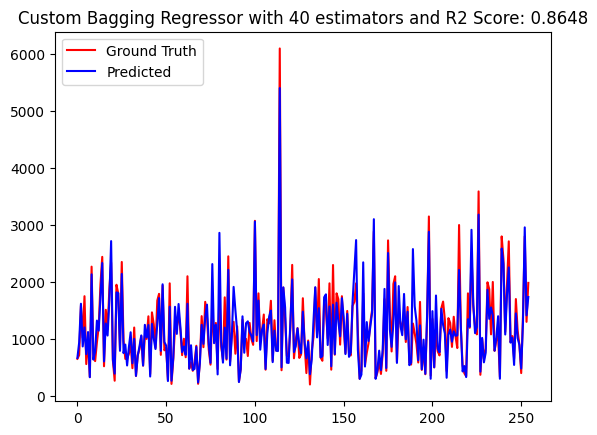

In [117]:
y_pred = best_model.predict(X_test)

plt.plot(y_test, color='red', label='Ground Truth')
plt.plot(y_pred, color='blue', label='Predicted')
plt.legend(loc='upper left')
plt.title(f"Custom Bagging Regressor with {best_estimators_number} estimators and R2 Score: {best_r2_score:.4f}")
plt.show()